In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Baffin = pd.read_excel(filepath, sheet_name='Baffin-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Baffin)
fp.date_time(Baffin)

,Extent,Date
0,1090625.815,1979-01-01
1,1157634.866,1979-02-01
2,1299583.477,1979-03-01
3,1137194.680,1979-04-01
4,983083.453,1979-05-01
...,...,...
533,781460.891,2023-06-01
534,331845.048,2023-07-01
535,99334.625,2023-08-01
536,49359.723,2023-09-01


In [5]:
scaler = MinMaxScaler()
Baffin['Extent'] = scaler.fit_transform(Baffin['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Baffin['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Baffin_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 22s 261ms/step - loss: 0.2165 - root_mean_squared_error: 0.4653 - val_loss: 0.1398 - val_root_mean_squared_error: 0.3739
Epoch 2/50
53/53 [==============================] - 15s 297ms/step - loss: 0.1202 - root_mean_squared_error: 0.3466 - val_loss: 0.0908 - val_root_mean_squared_error: 0.3013
Epoch 3/50
53/53 [==============================] - 13s 241ms/step - loss: 0.0919 - root_mean_squared_error: 0.3032 - val_loss: 0.0828 - val_root_mean_squared_error: 0.2878
Epoch 4/50
53/53 [==============================] - 15s 284ms/step - loss: 0.0855 - root_mean_squared_error: 0.2924 - val_loss: 0.0738 - val_root_mean_squared_error: 0.2716
Epoch 5/50
53/53 [==============================] - 11s 212ms/step - loss: 0.0756 - root_mean_squared_error: 0.2750 - val_loss: 0.0629 - val_root_mean_squared_error: 0.2509
Epoch 6/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0656 - root_mean_squared_error: 0.2561 - val_loss: 0.0465 

53/53 [==============================] - 2s 34ms/step - loss: 0.0106 - root_mean_squared_error: 0.1029 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 34/50
53/53 [==============================] - 14s 264ms/step - loss: 0.0108 - root_mean_squared_error: 0.1040 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 35/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 36/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0644
Epoch 37/50
53/53 [==============================] - 14s 264ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 38/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975 - val_loss: 0.0041 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.384474023183187 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

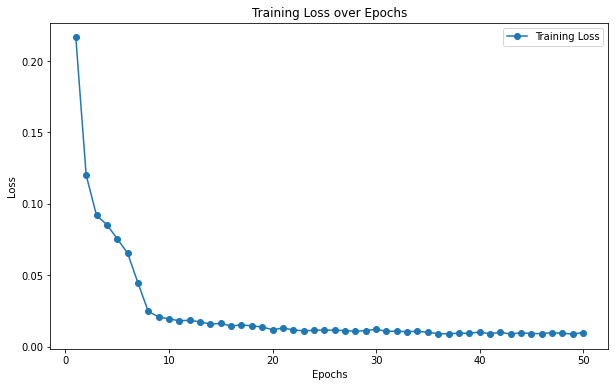

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

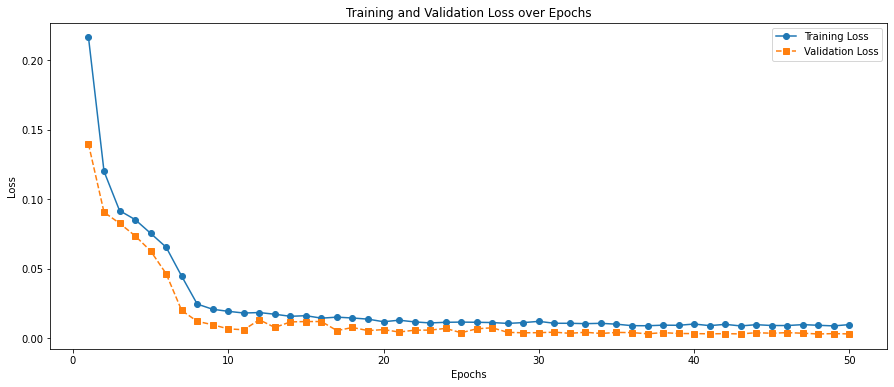

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Baffin_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 12ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06279027080332174
MAE : 0.05596709834130695


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.101395e+06,974461.347
1,1.246781e+06,1181121.087
2,1.260137e+06,1236299.254
3,1.125000e+06,1036981.003
4,8.572143e+05,847489.150
5,5.357788e+05,619129.338
6,2.665059e+05,195688.491
7,1.230637e+05,36670.811
8,7.994662e+04,31777.310
9,2.266260e+05,82762.022


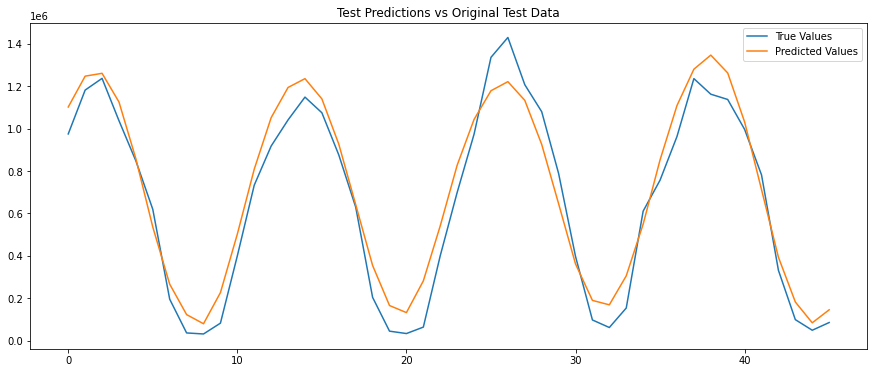

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

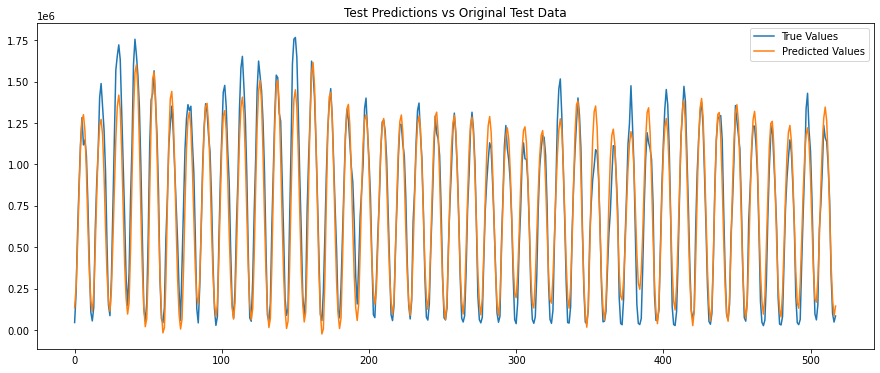

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()